In [1]:
from astropy import time
from datetime import datetime
import numpy as np
import cysgp4
from pyproj import Geod
from scepter import tleforger
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, SkyCoord, ITRS, GCRS
from astropy.constants import R_earth

from pycraf import conversions as cnv
from pycraf.antenna import ras_pattern
from scepter.antenna import s_1528_rec1_2_pattern
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.ndimage import uniform_filter1d
from scipy.optimize import root_scalar

In [25]:
import numpy as np
import plotly.express as px
from astropy import units as u
from scepter.antenna import s_1528_rec1_4_pattern_amend

# -----------------------------------------------------------
# 1. Helpers: global (θ, φ) -> 3D, then to local (θ_loc, φ_loc)
#    Global θ, φ are the S.1528 satellite reference angles.
# -----------------------------------------------------------
def sph_to_cart(theta_deg, phi_deg):
    """Global spherical (off-nadir θ, azimuth φ) -> 3D unit vector."""
    th = np.deg2rad(theta_deg)
    ph = np.deg2rad(phi_deg)
    x = np.sin(th) * np.cos(ph)
    y = np.sin(th) * np.sin(ph)
    z = np.cos(th)
    return np.stack([x, y, z], axis=-1)  # shape (..., 3)


def global_to_local(theta, phi, theta0, phi0):
    """
    Convert global (θ, φ) to local (θ_loc, φ_loc) around beam centre (θ0, φ0).

    θ_loc = angle between test direction and beam centre.
    φ_loc = azimuth in tangent plane, measured from the 'radial' direction
            (direction of increasing θ at fixed φ = φ0).
    """
    # Directions
    n  = sph_to_cart(theta,  phi)         # (..., 3)
    n0 = sph_to_cart(theta0, phi0)        # (3,)

    # Orthonormal basis at beam centre:
    #   e_theta0: along increasing global θ (radial in the A–B plane)
    #   e_phi0  : along increasing global φ (tangential)
    th0 = np.deg2rad(theta0)
    ph0 = np.deg2rad(phi0)

    e_theta0 = np.array([
        np.cos(th0) * np.cos(ph0),
        np.cos(th0) * np.sin(ph0),
        -np.sin(th0)
    ])  # unit, orthogonal to n0

    e_phi0 = np.array([
        -np.sin(ph0),
        np.cos(ph0),
        0.0
    ])  # unit, orthogonal to n0 and e_theta0

    # Components in local frame
    c_z = np.sum(n * n0, axis=-1)        # along beam axis
    c_x = np.sum(n * e_theta0, axis=-1)  # "radial" direction
    c_y = np.sum(n * e_phi0,   axis=-1)  # "tangential" direction

    # Local spherical angles
    theta_loc = np.rad2deg(np.arccos(np.clip(c_z, -1.0, 1.0)))
    phi_loc   = np.rad2deg(np.arctan2(c_y, c_x))

    return theta_loc, phi_loc


# -----------------------------------------------------------
# 2. Define global grid in satellite reference plane
# -----------------------------------------------------------
theta_global = np.linspace(0.0, 90.0, 181)     # off-nadir [deg]
phi_global   = np.linspace(-180.0, 180.0, 721)   # azimuth [deg]

TH, PH = np.meshgrid(theta_global, phi_global, indexing="ij")

# Beam centre in the *global* frame (θ0, φ0 from Rec. 1.4 style)
theta0 = 0.0   # [deg]
phi0   = 90.0   # [deg]

# -----------------------------------------------------------
# 3. Convert to local offsets and evaluate S.1528 pattern
# -----------------------------------------------------------
theta_loc, phi_loc = global_to_local(TH, PH, theta0, phi0)

# Your pattern function expects offsets in degrees
gain = s_1528_rec1_4_pattern_amend(theta_loc*u.deg, phi_loc*u.deg,
                                   Lr=0.35*u.m,Lt=0.35*u.m).value  # dBi


# -----------------------------------------------------------
# 4. Project global (θ, φ) onto satellite reference plane
#    x = θ cosφ, y = θ sinφ   (φ truly is atan2(y, x))
# -----------------------------------------------------------
x = TH * np.cos(np.deg2rad(PH))
y = TH * np.sin(np.deg2rad(PH))

# -----------------------------------------------------------
# 5. Plot with Plotly
# -----------------------------------------------------------
fig = px.scatter(
    x=x.ravel(),
    y=y.ravel(),
    color=gain.ravel(),
    color_continuous_scale="Viridis",
    labels={"color": "Gain (dBi)"},
)

fig.update_traces(marker=dict(size=3))

fig.update_layout(
    title=(
        "S.1528 Recommends 1-4 Pattern in Satellite Reference Plane<br>"
        f"Beam centre at θ₀={theta0}°, φ₀={phi0}°"
    ),
    xaxis_title="x = θ · cos φ  [deg]",
    yaxis_title="y = θ · sin φ  [deg]",
    yaxis_scaleanchor="x",
    width=750,
    height=750,
)

fig.show()


In [29]:
from pycraf.geometry import true_angular_distance
from astropy import units as u
a=true_angular_distance(0*u.deg, (90-0)*u.deg, 10*u.deg, (90-10)*u.deg)
print(a)

10.0 deg


In [ ]:
import numpy as np
import plotly.graph_objects as go

# ---------- helpers: user (θ from south pole, φ as lon) → 3D ----------

def sph_to_cart_south(theta_deg, phi_deg, r=1.0):
    """
    θ: 0° = south pole, 90° = equator
    φ: longitude (deg)
    """
    theta_rad = np.deg2rad(theta_deg)
    phi_rad   = np.deg2rad(phi_deg)

    lam = np.pi - theta_rad              # colatitude from *north* pole
    x = r * np.sin(lam) * np.cos(phi_rad)
    y = r * np.sin(lam) * np.sin(phi_rad)
    z = r * np.cos(lam)
    return x, y, z


def global_to_local(theta, phi, theta0, phi0):
    """
    Global (θ, φ) → local (θ_loc, φ_loc) around beam centre (θ0, φ0),
    with θ measured from south pole.
    """
    theta = np.asarray(theta)
    phi   = np.asarray(phi)

    # Directions for all test points and for beam centre
    lam   = np.pi - np.deg2rad(theta)
    lam0  = np.pi - np.deg2rad(theta0)
    ph    = np.deg2rad(phi)
    ph0   = np.deg2rad(phi0)

    n = np.stack([
        np.sin(lam) * np.cos(ph),
        np.sin(lam) * np.sin(ph),
        np.cos(lam)
    ], axis=-1)

    n0 = np.array([
        np.sin(lam0) * np.cos(ph0),
        np.sin(lam0) * np.sin(ph0),
        np.cos(lam0)
    ])

    # Local orthonormal basis at beam centre:
    #   e_theta0 : increasing θ (in meridian plane)
    #   e_phi0   : increasing φ (eastward)
    e_theta0 = np.array([
        -np.cos(lam0) * np.cos(ph0),
        -np.cos(lam0) * np.sin(ph0),
         np.sin(lam0)
    ])
    e_phi0 = np.array([
        -np.sin(ph0),
         np.cos(ph0),
         0.0
    ])

    c_z = np.sum(n * n0,       axis=-1)     # along beam axis
    c_x = np.sum(n * e_theta0, axis=-1)     # local "radial"
    c_y = np.sum(n * e_phi0,   axis=-1)     # local "tangential"

    theta_loc = np.rad2deg(np.arccos(np.clip(c_z, -1.0, 1.0)))
    phi_loc   = np.rad2deg(np.arctan2(c_y, c_x))

    return theta_loc, phi_loc


# ---------- 1. Global grid on the sphere cap ----------

theta_global = np.linspace(0.0, 90.0, 181)      # 0 = south pole, 90 = equator
phi_global   = np.linspace(-180.0, 180.0, 721)   # longitude span (adjust as needed)

TH, PH = np.meshgrid(theta_global, phi_global, indexing="ij")

# Beam centre in global coordinates (same convention: θ from south pole)
theta0 = 30.0   # deg
phi0   = 20.0   # deg

# ---------- 2. Convert to local offsets and evaluate pattern ----------

theta_loc, phi_loc = global_to_local(TH, PH, theta0, phi0)

# Your Taylor pattern expects offsets around beam axis
gain = s_1528_rec1_4_pattern_amend(theta_loc*u.deg, phi_loc*u.deg,
                                   Lr=0.35*u.m,Lt=0.35*u.m).value  # dBi


# ---------- 3. Map global (θ, φ) to 3D sphere section ----------

X, Y, Z = sph_to_cart_south(TH, PH, r=1.0)


# ---------- 4. Plot: spherical cap coloured by gain ----------

fig = go.Figure(
    data=go.Surface(
        x=X,
        y=Y,
        z=Z,
        surfacecolor=gain,
        colorscale="Viridis",
        colorbar=dict(title="Gain (dBi)"),
        showscale=True,
    )
)

fig.update_layout(
    title=(
        "S.1528 Recommends 1-4 Beam on Spherical Cap<br>"
        f"Beam centre at θ₀={theta0}°, φ₀={phi0}°"
    ),
    scene=dict(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="z",
        aspectmode="data",
    ),
)

fig.show()


# ========================
# Chapter I. Calculations
# ========================

In [2]:
# --------------------------------------------------------
# 1) Time range
# --------------------------------------------------------
start_time = time.Time(datetime(2025, 1, 1, 0, 0, 0))
timestep = 1 # steps in seconds
td = time.TimeDelta(np.arange(0, 0.05*3600*24, timestep), format='sec')  # x days above steps
times = start_time + td
n_times = len(times)  # total frames
print(f'Number of timeframes: {n_times}')

Number of timeframes: 4320


In [3]:
# --------------------------------------------------------
# 2) RAS Observatory definition
# --------------------------------------------------------
latitude = -30.712777 * u.deg
longitude = 21.443611 * u.deg
elevation = 1052.0 * u.m
SKAO=cysgp4.PyObserver(longitude.value,latitude.value,elevation.to(u.km).value)
obs_location = EarthLocation(lat=latitude, lon=longitude, height=elevation)

observer_list=[SKAO]

pointing_az = 45 * u.deg
pointing_el = 15 * u.deg
SKAO_ant_diam = 15 * u.m

print(f'RAS stations defined as {observer_list} and {obs_location}')
observer_list=np.array(observer_list)

RAS stations defined as [<PyObserver: 21.4436d, -30.7128d, 1.0520km>] and (5109251.44062577, 2006781.29056739, -3239094.56419218) m


In [4]:
# --------------------------------------------------------
# 3) Satellite batch creation
# --------------------------------------------------------
belt_names = []
belt_sats = []
altitudes = []
max_deviation_angles = []
tle_list = []

# belt_name='SystemA_Belt_1'
# num_sats_per_plane = 28
# plane_count = 28
# altitude_km = 590
# eccentricity = 0.0
# inclination_deg = 33
# argp_deg = 0.0
# RAAN_min = 0
# RAAN_max = 360
# altitudes_km=np.append(altitudes_km, altitude_km)

# System_A1_tle_list = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, plane_count=plane_count, RAAN_min=RAAN_min, RAAN_max=RAAN_max, altitude_m=altitude_km*1000, eccentricity=eccentricity, inclination_deg=inclination_deg, argp_deg=argp_deg, adjacent_plane_offset=False)

# belt_name='SystemA_Belt_2'
# num_sats_per_plane = 36
# plane_count = 36
# altitude_km = 610
# eccentricity = 0.0
# inclination_deg = 42
# argp_deg = 0.0
# RAAN_min = 0
# RAAN_max = 360
# altitudes_km=np.append(altitudes_km, altitude_km)

# System_A2_tle_list = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, plane_count=plane_count, RAAN_min=RAAN_min, RAAN_max=RAAN_max, altitude_m=altitude_km*1000, eccentricity=eccentricity, inclination_deg=inclination_deg, argp_deg=argp_deg, adjacent_plane_offset=False)

# belt_name='SystemA_Belt_3'
# num_sats_per_plane = 34
# plane_count = 34
# altitude_km = 630
# eccentricity = 0.0
# inclination_deg = 51.9
# argp_deg = 0.0
# RAAN_min = 0
# RAAN_max = 360
# altitudes_km=np.append(altitudes_km, altitude_km)

# System_A3_tle_list = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, plane_count=plane_count, RAAN_min=RAAN_min, RAAN_max=RAAN_max, altitude_m=altitude_km*1000, eccentricity=eccentricity, inclination_deg=inclination_deg, argp_deg=argp_deg, adjacent_plane_offset=False)

# belt_name='SystemB_Belt_1'
# num_sats_per_plane = 120
# plane_count = 28
# altitude_km = 525
# eccentricity = 0.0
# inclination_deg = 53
# argp_deg = 0.0
# RAAN_min = 0
# RAAN_max = 360
# altitudes_km=np.append(altitudes_km, altitude_km)

# System_B1_tle_list = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, plane_count=plane_count, RAAN_min=RAAN_min, RAAN_max=RAAN_max, altitude_m=altitude_km*1000, eccentricity=eccentricity, inclination_deg=inclination_deg, argp_deg=argp_deg, adjacent_plane_offset=False)

# belt_name='SystemB_Belt_2'
# num_sats_per_plane = 120
# plane_count = 28
# altitude_km = 530
# eccentricity = 0.0
# inclination_deg = 43
# argp_deg = 0.0
# RAAN_min = 0
# RAAN_max = 360
# altitudes_km=np.append(altitudes_km, altitude_km)

# System_B2_tle_list = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, plane_count=plane_count, RAAN_min=RAAN_min, RAAN_max=RAAN_max, altitude_m=altitude_km*1000, eccentricity=eccentricity, inclination_deg=inclination_deg, argp_deg=argp_deg, adjacent_plane_offset=False)

# belt_name='SystemB_Belt_3'
# num_sats_per_plane = 28
# plane_count = 24
# altitude_km = 535
# eccentricity = 0.0
# inclination_deg = 33
# argp_deg = 0.0
# RAAN_min = 0
# RAAN_max = 360
# altitudes_km=np.append(altitudes_km, altitude_km)

# System_B3_tle_list = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, plane_count=plane_count, RAAN_min=RAAN_min, RAAN_max=RAAN_max, altitude_m=altitude_km*1000, eccentricity=eccentricity, inclination_deg=inclination_deg, argp_deg=argp_deg, adjacent_plane_offset=False)

# belt_name='SystemB_Belt_4'
# num_sats_per_plane = 27
# plane_count = 4
# altitude_km = 535
# eccentricity = 0.0
# inclination_deg = 33
# argp_deg = 0.0
# RAAN_min = 0
# RAAN_max = 360
# altitudes_km=np.append(altitudes_km, altitude_km)

# System_B4_tle_list = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, plane_count=plane_count, RAAN_min=RAAN_min, RAAN_max=RAAN_max, altitude_m=altitude_km*1000, eccentricity=eccentricity, inclination_deg=inclination_deg, argp_deg=argp_deg, adjacent_plane_offset=False)

belt_name='SystemC_Belt_1'
num_sats_per_plane = 40
plane_count = 18
altitude = 1200 * u.km
eccentricity = 0.0
inclination_deg = 87.9 * u.deg
argp_deg = 0.0 * u.deg
RAAN_min = 0 * u.deg
RAAN_max = 180 * u.deg
max_deviation_angle = np.arcsin(R_earth / (R_earth + altitude)).to(u.deg)

System_C_tle_list = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, plane_count=plane_count, RAAN_min=RAAN_min, RAAN_max=RAAN_max, altitude=altitude, eccentricity=eccentricity, inclination_deg=inclination_deg, argp_deg=argp_deg, adjacent_plane_offset=False)
belt_names.append(belt_name)
belt_sats.append(len(System_C_tle_list))
altitudes.append(altitude)
max_deviation_angles.append(max_deviation_angle)
tle_list.extend(System_C_tle_list)

belt_sats = np.array(belt_sats)
altitudes = np.array(altitudes, dtype=object)
max_deviation_angles = np.array(max_deviation_angles, dtype=object)
tle_list = np.array(tle_list, dtype=object)

format_func = np.vectorize(lambda x: f"{x:.2f}")

n_sats = len(tle_list)
print(f'Total number of satellites: {n_sats}')
print(f'Defined belts are {belt_names} with number of sats per belt {belt_sats} at altitudes {format_func(altitudes)}. \nTheir max offset β angles are {format_func(max_deviation_angles)}')

Total number of satellites: 720
Defined belts are ['SystemC_Belt_1'] with number of sats per belt [720] at altitudes ['1200.00 km']. 
Their max offset β angles are ['57.31 deg']


In [5]:
highest_altitude = np.max(altitudes)
slant_distance = (np.sqrt((R_earth + highest_altitude)**2 - (R_earth * np.cos(pointing_el.to(u.rad)))**2) - R_earth * np.sin(pointing_el.to(u.rad))).to(u.km)
slant_distance_max = (np.sqrt((R_earth + highest_altitude)**2 - (R_earth)**2)).to(u.km)
max_deviation_angle = np.arcsin(R_earth / (R_earth + highest_altitude)).to(u.deg)
print(f'Highest altitude is {highest_altitude:.2f}\nSlant path for that altitude and {pointing_el:.2f} elevation is {slant_distance:.2f}\nMaximum slant path possible {slant_distance_max:.2f} at {max_deviation_angle:.2f} offset β angle')

Highest altitude is 1200.00 km
Slant path for that altitude and 15.00 deg elevation is 2761.99 km
Maximum slant path possible 4092.36 km at 57.31 deg offset β angle


In [24]:
# --------------------------------------------------------------------
# 4) Calculating satellite and observers positions in ECI frame
# --------------------------------------------------------------------

#Reshaping the inputs
observers_new=observer_list[np.newaxis, :, np.newaxis]
mjds_new=times.mjd[:, np.newaxis, np.newaxis]
tles_new=tle_list[np.newaxis, np.newaxis, :]

result = cysgp4.propagate_many(mjds_new, 
                               tles_new, 
                               observers_new, 
                               do_eci_pos=True, 
                               do_eci_vel=False, 
                               do_geo=False, 
                               do_topo=True,
                               do_obs_pos=True,
                               do_sat_azel=True,
                               do_sat_rotmat=False,
                               sat_frame='xyz')
sat_eci_pos=result['eci_pos'] # satellite positions in ECI frame (x,y,z)
sat_topo=result['topo'] # satellite positions for observers (az,el,dist,dist_rate)
obs_eci_pos=result['obs_pos'] # observer positions in ECI frame (x,y,z)
sat_azel=result['sat_azel'] # anges to observer in local satellite frames
# Shape is (times, observers, satellites,...)

distances = sat_topo[:,:,:,2] * u.km
distancesX = distances
visibility_matrix = sat_topo[:,:,:,1] > 0
distances[~visibility_matrix] = np.inf * u.km
print(f"The results will have following shape for (timestep, observer, satellite) dimentions: {np.shape(distances)}")

Nco = 1
T, O, S = visibility_matrix.shape
rand_vals = np.random.rand(T, O, S)
rand_vals[~visibility_matrix] = -np.inf # invisible satellites should be ignored
sorted_indices = np.argsort(-rand_vals, axis=-1)
topN = sorted_indices[..., :Nco] # these will be indexes of active satellites
selected_rand = np.take_along_axis(rand_vals, topN, axis=-1)
mask = selected_rand > -np.inf
activation_matrix = np.zeros((T, O, S), dtype=bool)
t_idx, o_idx = np.indices((T, O))
activation_matrix[t_idx[..., None], o_idx[..., None], topN] = mask
# print(topN[:,0,:]) # - uncomment to see which satellites were selected to serve the immediate RAS area

The results will have following shape for (timestep, observer, satellite) dimentions: (4320, 1, 720)


In [7]:
# ------------------------------------------
# 5) Setting antenna pointings
# ------------------------------------------
# RAS antenna off-axis calculation
sat_az = sat_topo[:,:,:,0] * u.deg
sat_el = sat_topo[:,:,:,1] * u.deg

altaz_frame = AltAz(obstime=times[:, np.newaxis, np.newaxis], location=obs_location)

antenna_coord = SkyCoord(
    az=pointing_az,
    alt=pointing_el,
    distance=1*u.AU,
    frame=altaz_frame
)
satellite_coords = SkyCoord(
    az=sat_az,
    alt=sat_el,
    distance=1*u.AU,
    frame=altaz_frame
)

# This will populate ofset angles for 
offset_angles = satellite_coords.separation(antenna_coord)
offset_deg_grx = offset_angles.deg
print(f"Offset angles from RAS main direction towards each satellite shape is {np.shape(offset_angles)}")


# ----------------------------------------------------------------------------------------------------------------
# Satellite antennas off-axis calculation
# Get pointings to RAS station from each satellite
ras_az = sat_azel[:,:,:,0] * u.deg
ras_el = sat_azel[:,:,:,1] * u.deg
# Get shape from activation_matrix: (T, O, S). Redundant, but useful to see what is used as indexes origin
T, O, S = activation_matrix.shape

# Create arrays for the antenna pointing directions of each satellite (in degrees)
sat_antenna_az = np.empty((T, O, S))
sat_antenna_el = np.empty((T, O, S))

# Generate random values for non-activated satellites:
# Random azimuth: full circle (0 to 360 degrees)
random_az = np.random.uniform(0, 360, size=(T, O, S)) * u.deg
max_el = max_deviation_angles[0].to(u.deg).value
random_el = np.random.uniform(0, max_el, size=(T, O, S)) * u.deg

sat_antenna_az = np.where(activation_matrix, ras_az, random_az)
sat_antenna_el = np.where(activation_matrix, ras_el, random_el)

ras_coords_from_sat = SkyCoord(
    az=ras_az,
    alt=90*u.deg - ras_el,
    distance=1*u.AU,
    frame=altaz_frame
)
sat_antenna_coord = SkyCoord(
    az=sat_antenna_az,
    alt=90*u.deg - sat_antenna_el,
    distance=1*u.AU,
    frame=altaz_frame
) # az, alt = 0, 90 deg for nadir
# Compute the separation angle between the satellite antenna pointing and the RAS station in satellite frame.
offset_angles_gtx = sat_antenna_coord.separation(ras_coords_from_sat)
# Extract the offset angles in degrees for gain calculation.
offset_deg_gtx = offset_angles_gtx.deg
print(f"Offset angles from each satellite main direction towards RAS shape is {np.shape(offset_angles)}")

Offset angles from RAS main direction towards each satellite shape is (4320, 1, 720)
Offset angles from each satellite main direction towards RAS shape is (4320, 1, 720)


In [33]:
# ------------------------------------------
# 5.5) Getting slant pathes to antenna pointings
# ------------------------------------------
d_slant = (R_earth + highest_altitude) * np.cos(sat_antenna_el.to(u.rad)) - np.sqrt(R_earth**2 - (R_earth + highest_altitude)**2 * np.sin(sat_antenna_el.to(u.rad))**2)
print("Slant path shape:", d_slant.shape)

Slant path shape: (4320, 1, 720)


In [10]:
# --------------------------------------------------------
# 6) Calculating the received power
# --------------------------------------------------------
FREQUENCY = 10.7 * u.GHz
wavelength = FREQUENCY.to(u.m, equivalencies=u.spectral())  

powerflux = - 121 * cnv.dB_W_m2
gtx, Gm, _ = s_1528_rec1_2_pattern(offset_deg_gtx * u.deg)
Ptx = cnv.ptx_from_powerflux(powerflux, altitude, Gm) # try to use real distances instead of just one height

grx = ras_pattern(offset_deg_grx * u.deg, SKAO_ant_diam, wavelength)
Prx = cnv.prx_from_ptx(Ptx, gtx, grx, distances, FREQUENCY)
Prx_log = np.full_like(Prx.value, np.nan)
Prx_log[Prx.value>0] = 10 * np.log10(Prx.value[Prx.value>0])
total_Prx=np.sum(Prx, axis=2)[:,0]
total_Prx_log = np.full_like(total_Prx.value, np.nan)
total_Prx_log[total_Prx.value>0] = 10 * np.log10(total_Prx.value[total_Prx.value>0])

In [11]:
# ------------------------------------------
# 7) Calculating boresight avoidance scenario
# ------------------------------------------
# Define the boresight avoidance threshold (in degrees)
boresight_threshold = 10.0  # satellites with offset < 10° will be avoided
# Mark satellites within the boresight threshold (offset < 10°) as switched off by setting their distance to infinity.
distances[offset_deg_grx < boresight_threshold] = np.inf * u.km
# Create a boresight mask: True where the off-axis angle is greater than or equal to the threshold
boresight_mask = offset_deg_grx >= boresight_threshold
# Combine the original visibility_matrix with the boresight condition:
visibility_matrix_avoid = np.logical_and(visibility_matrix, boresight_mask)

T, O, S = visibility_matrix_avoid.shape

# Generate random values (the same as before) but use the modified visibility matrix
rand_vals_avoid = np.random.rand(T, O, S)
rand_vals_avoid[~visibility_matrix_avoid] = -np.inf  # mark non-visible satellites as -∞

# Sort the random values along the satellite axis (last axis)
sorted_indices_avoid = np.argsort(-rand_vals_avoid, axis=-1)

# Select the top Nco indices (active satellites) for each (time, observer)
topN_avoid = sorted_indices_avoid[..., :Nco]
selected_rand_avoid = np.take_along_axis(rand_vals_avoid, topN_avoid, axis=-1)
mask_avoid = selected_rand_avoid > -np.inf

# Create the activation matrix (same shape as before)
activation_matrix_avoid = np.zeros((T, O, S), dtype=bool)
t_idx, o_idx = np.indices((T, O))
activation_matrix_avoid[t_idx[..., None], o_idx[..., None], topN_avoid] = mask_avoid

sat_antenna_az = np.where(activation_matrix_avoid, ras_az, random_az)
sat_antenna_el = np.where(activation_matrix_avoid, ras_el, random_el)

sat_antenna_coord = SkyCoord(
    az=sat_antenna_az,
    alt=90*u.deg - sat_antenna_el,
    distance=1*u.AU,
    frame=altaz_frame
)
offset_angles_gtx = sat_antenna_coord.separation(ras_coords_from_sat)
offset_deg_gtx = offset_angles_gtx.deg
gtx, Gm, _ = s_1528_rec1_2_pattern(offset_deg_gtx * u.deg)
Ptx = cnv.ptx_from_powerflux(powerflux, altitude, Gm)
Prx = cnv.prx_from_ptx(Ptx, gtx, grx, distances, FREQUENCY)
Prx_log = np.full_like(Prx.value, np.nan)
Prx_log[Prx.value>0] = 10 * np.log10(Prx.value[Prx.value>0])
total_Prx_avoid=np.sum(Prx, axis=2)[:,0]
total_Prx_log_avoid = np.full_like(total_Prx_avoid.value, np.nan)
total_Prx_log_avoid[total_Prx_avoid.value>0] = 10 * np.log10(total_Prx_avoid.value[total_Prx_avoid.value>0])

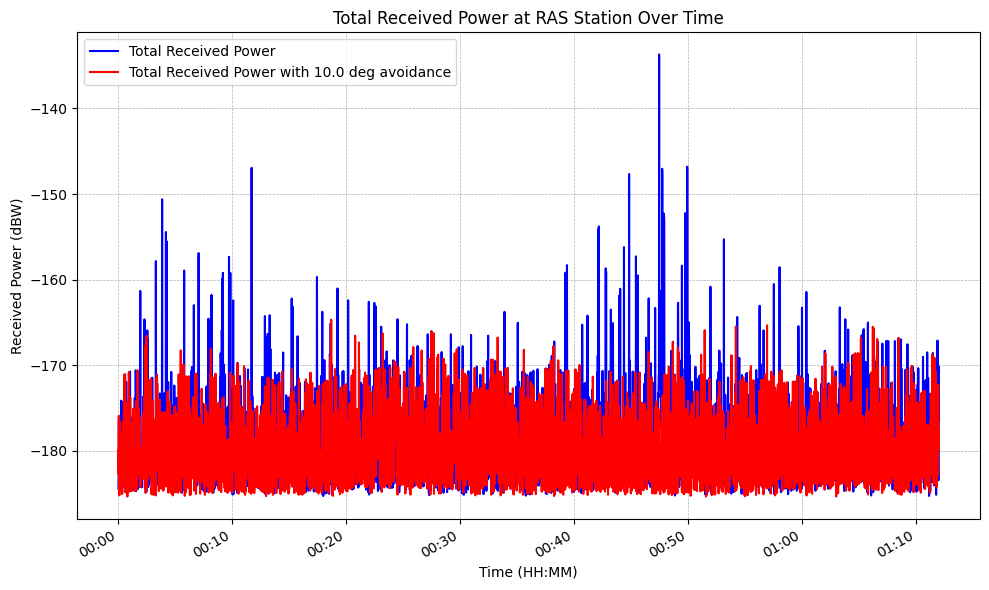

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert astropy Time to datetime objects for plotting.
time_datetimes = times.datetime

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the total received power (dBW) vs. time.
ax.plot(time_datetimes, total_Prx_log, linestyle='-', color='b', label='Total Received Power')
ax.plot(time_datetimes, total_Prx_log_avoid, linestyle='-', color='r', label=f'Total Received Power with {boresight_threshold} deg avoidance')
# window_size = int(2000 / timestep)
# smoothed_power = uniform_filter1d(total_Prx_log, size=window_size)
# ax.plot(time_datetimes, smoothed_power, linestyle='-', color='r', label='Smoothed Received Power')

# Add grid with light dashed lines.
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Format the x-axis: use AutoDateLocator for good tick spacing and DateFormatter for HH:MM.
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()  # Auto-rotate date labels

# Set axis labels and title.
ax.set_xlabel("Time (HH:MM)")
ax.set_ylabel("Received Power (dBW)")
ax.set_title("Total Received Power at RAS Station Over Time")
ax.legend()

plt.tight_layout()
plt.show()

In [13]:
# Calculating auxilarity data to draw -3 dB cone
grx_max=ras_pattern(0 * u.deg, SKAO_ant_diam, wavelength)
def gain_difference(theta):
    gain = ras_pattern(theta * u.deg, SKAO_ant_diam, wavelength).value
    return gain - 0
minus3dB_point = root_scalar(gain_difference, bracket=[0, 180], method='brentq').root

In [14]:
print(minus3dB_point)

13.593563908785255


# --------------------------------------------------------
# Chapter II. Visualisation
# --------------------------------------------------------

In [15]:
import pyvista as pv
from sys import platform
import vtk
vtk.vtkObject.GlobalWarningDisplayOff()
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# Animation would be stored to the movie. If SAVE_MOVIE is False, only static 3D scenery of last timestamp will be shown
SAVE_MOVIE=False
movie_name="earth_station_anim_North-East_satNadir.mp4"
SKYBOX=False

# For remote execution
if platform == "linux" or platform == "linux2":
    pv.start_xvfb()
    pv.global_theme.trame.jupyter_extension_enabled=False
    pv.global_theme.trame.server_proxy_enabled=True
    pv.global_theme.trame.server_proxy_prefix='/proxy/'
    pv.set_jupyter_backend('client')

In [16]:
power_cmap = plt.colormaps['jet']
power_range = np.array([np.nanmin(Prx_log), np.nanmax(Prx_log)])
print(power_range)

[-222.75701353 -164.68330353]


In [17]:
EarthMesh=pv.examples.planets.load_earth()
EarthMesh.scale(R_earth.to(u.km).value, inplace=True)
earth_texture = pv.examples.load_globe_texture()
theta_deg_correction = np.degrees(np.arctan2(obs_eci_pos[0,0,0,1], obs_eci_pos[0,0,0,0])) - longitude.to(u.deg).value
EarthMesh.rotate_z(-180+theta_deg_correction, point=(0,0,0), inplace=True)

pl = pv.Plotter(off_screen=True)

if SKYBOX:
    cubemap = pv.examples.download_cubemap_space_16k()
    _ = pl.add_actor(cubemap.to_skybox())
    pl.set_environment_texture(cubemap, True)
else:    
    image_path = pv.examples.planets.download_stars_sky_background(load=False)
    pl.add_background_image(image_path)


earth_actor = pl.add_mesh(
    EarthMesh,
    texture=earth_texture,
    smooth_shading=True,
    name="Earth"
)

# RAS Station visualisation
station_sphere = pv.Sphere(radius=100)
station_actor = pl.add_mesh(
    station_sphere,
    color='magenta',
    smooth_shading=True,
    name="SKAO RAS station"
)
station_actor.SetPosition(obs_eci_pos[0,0,0,0], obs_eci_pos[0,0,0,1], obs_eci_pos[0,0,0,2])

# Satellites visualisation
satellite_positions = sat_eci_pos[0, 0, :, :3]
satellite_points = pv.PolyData(satellite_positions)
satellite_sphere = pv.Sphere(radius=35)
satellite_points["Interference Power, dBW"] = Prx_log[0, 0, :]

glyph = satellite_points.glyph(
    geom=satellite_sphere,
    scale=False,
    orient=False
)

glyph_actor = pl.add_mesh(
    glyph,
    scalars="Interference Power, dBW",
    cmap=power_cmap,
    clim=power_range,
    nan_color="black",
    smooth_shading=True,
    name="SatellitesGlyph",
    show_scalar_bar=False
)

sbar = pl.add_scalar_bar(
    title='Interference Power, dBW\n', 
    n_labels=10,
    position_x=0.85,
    position_y=0.1,
    width=0.06,
    height=0.8,
    vertical=True,
    color='white',
    background_color=[0,0,0],
    fill=True,
    shadow=True
)



# Camera control block
sph_cam = SphericalRepresentation(
    longitude+theta_deg_correction*u.deg,    # longitude
    latitude/2,    # latitude
    distance=(R_earth+np.max(altitudes))*5
)
cart_cam = sph_cam.represent_as(CartesianRepresentation)

pl.camera_position = [
    (cart_cam.x.to(u.km).value, cart_cam.y.to(u.km).value, cart_cam.z.to(u.km).value),  # camera
    (0, 0, 0),                # focal point
    (0, 0, 1)                 # view-up vector
]

In [18]:
# Auxilarity block
# Cone definition
# First create the pointing vector in local horizontal frame
antenna_coord_itrf = antenna_coord.transform_to(ITRS())
antenna_coord_gcrs = antenna_coord.transform_to(GCRS())

station_itrf = SkyCoord(obs_location.get_itrs(obstime=times[:, np.newaxis, np.newaxis]))
station_gcrs = station_itrf.transform_to(GCRS(obstime=times[:, np.newaxis, np.newaxis]))

direction_gcrs = station_gcrs.cartesian.xyz[:,:,0,0] - antenna_coord_gcrs.cartesian.xyz[:,:,0,0]
direction_gcrs_norm = (direction_gcrs / np.linalg.norm(direction_gcrs, axis=0)[np.newaxis, :]).T

d_eci = direction_gcrs_norm[0,:].value


cone_height = slant_distance_max.value

cone_apex_location=obs_eci_pos[0,0,0,:]
ray_trace_end_location= cone_apex_location - cone_height * d_eci

cone_angle=10
cone = pv.Cone(
    center=(cone_apex_location-0.5 * cone_height * d_eci),
    direction=d_eci,
    height=cone_height,
    angle=cone_angle,
    resolution=16
)
orbital_belt_spheres = np.empty(len(altitudes), dtype=object)
for idx, altitude_km in enumerate(altitudes):
    orbital_belt_spheres[idx] = pv.Sphere(radius=R_earth.to(u.km).value+altitude_km.to(u.km).value, theta_resolution=180, phi_resolution=90)
colors = [
    '#FF0000'   # RED
]
intersection_actors_cone = np.empty(len(altitudes), dtype=object)
intersection_actors_dots = np.empty(len(altitudes), dtype=object)
for idx, altitude_km in enumerate(altitudes):
    intersection_cone, _, _ = cone.intersection(orbital_belt_spheres[idx])
    intersection_actors_cone[idx] = pl.add_mesh(intersection_cone, color=colors[idx], line_width=5)
    points, _ = orbital_belt_spheres[idx].ray_trace(cone_apex_location, ray_trace_end_location)
    intersection = pv.PolyData(points)
    intersection_actors_dots[idx] = pl.add_mesh(intersection, color=colors[idx], point_size=5, render_points_as_spheres=True)
cone_actor = pl.add_mesh(
    cone.triangulate().boolean_intersection(orbital_belt_spheres[-1].triangulate()),
    color='magenta',
    opacity=0.25,  # 75% transparent
    smooth_shading=True,
    name="3dB_cone"
)
rot_angle = 360 * timestep / 86400.0

In [19]:
if SAVE_MOVIE :
    pl.render_window.SetOffScreenRendering(True)
    pl.render_window.SetUseOffScreenBuffers(True)
    pl.open_movie(str(movie_name), framerate=60, quality=10, bitrate="10M") # h264_nvenc only works with Nvidia GPU. Need to change to 'h264_amf' for AMD or 'h264_qsv' for Intel
    for i in tqdm(range(n_times), desc='Processing animation frames:'):
        # 1) Apply rotation to Earth mesh to simulate Earth rotation
        EarthMesh.rotate_z(rot_angle, point=(0,0,0), inplace=True)

        # 1.1) Simulate ECEF frame by rotating camera ensuring its longitude is the same as the RAS station
        total_rot_angle=rot_angle*i
        sph_cam = SphericalRepresentation(
            longitude+(theta_deg_correction+total_rot_angle)*u.deg,    # longitude
            latitude/2,    # latitude
            distance=R_earth*5
        )
        cart_cam = sph_cam.represent_as(CartesianRepresentation)
        pl.camera_position = [
            (cart_cam.x.to(u.km).value, cart_cam.y.to(u.km).value, cart_cam.z.to(u.km).value),  # camera
            (0, 0, 0),                # focal point
            (0, 0, 1)                 # view-up vector
        ]

        # 2) Update RASstation position
        station_actor.SetPosition(obs_eci_pos[i,0,0,0], obs_eci_pos[i,0,0,1], obs_eci_pos[i,0,0,2])

        # 3) Update satellites positions
        satellite_points.points[:] = sat_eci_pos[i, 0, :, :]
        satellite_points["Interference Power, dBW"] = Prx_log[i, 0, :]
        glyph = satellite_points.glyph(
            geom=satellite_sphere,
            scale=False,
            orient=False
        )
        glyph_actor.mapper.SetInputData(glyph)

        # 4) Create 3dB cone
        d_eci = direction_gcrs_norm[i,:].value
        cone_apex_location=obs_eci_pos[i,0,0,:]
        ray_trace_end_location= cone_apex_location - 2*slant_distance.value * d_eci

        cone = pv.Cone(
            center=(obs_eci_pos[i,0,0,:]-0.5 * cone_height * d_eci),
            direction=d_eci,
            height=cone_height,
            angle=minus3dB_point,
            resolution=16
        )
        cone_actor = pl.add_mesh(
            cone.triangulate().boolean_intersection(orbital_belt_spheres[-1].triangulate()),
            color='magenta',
            opacity=0.25,  # 75% transparent
            smooth_shading=True,
            name="3dB_cone"
        )

        for idx, _ in enumerate(intersection_actors_cone):
            pl.remove_actor(intersection_actors_cone[idx])
            intersection, s1_split, s2_split = cone.intersection(orbital_belt_spheres[idx])
            intersection_actors_cone[idx] = pl.add_mesh(intersection, color=colors[idx], line_width=7)
            
            pl.remove_actor(intersection_actors_dots[idx])
            points, _ = orbital_belt_spheres[idx].ray_trace(cone_apex_location, ray_trace_end_location)
            intersection = pv.PolyData(points)
            intersection_actors_dots[idx] = pl.add_mesh(intersection, color=colors[idx], point_size=5, render_points_as_spheres=True)

        # 5) Render and write frame
        pl.render()
        pl.write_frame()
    pl.close()
else:
    # 1) Apply rotation to Earth mesh to simulate Earth rotation
    total_rot_angle=rot_angle*n_times
    EarthMesh.rotate_z(total_rot_angle, point=(0,0,0), inplace=True) 
    # 1.1) Simulate ECEF frame by rotating camera ensuring its longitude is the same as the RAS station   
    sph_cam = SphericalRepresentation(
        longitude+(theta_deg_correction+total_rot_angle)*u.deg,    # longitude
        latitude/2,    # latitude
        distance=R_earth*5
    )
    cart_cam = sph_cam.represent_as(CartesianRepresentation)
    pl.camera_position = [
        (cart_cam.x.to(u.km).value, cart_cam.y.to(u.km).value, cart_cam.z.to(u.km).value),  # camera
        (0, 0, 0),                # focal point
        (0, 0, 1)                 # view-up vector
    ]
    # 2) Update RASstation position
    station_actor.SetPosition(obs_eci_pos[-1,0,0,0], obs_eci_pos[-1,0,0,1], obs_eci_pos[-1,0,0,2])

    
    # 3) Update satellites positions
    satellite_points.points[:] = sat_eci_pos[-1, 0, :, :]
    satellite_points["Interference Power, dBW"] = Prx_log[-1, 0, :]
    glyph = satellite_points.glyph(
        geom=satellite_sphere,
        scale=False,
        orient=False
    )
    glyph_actor.mapper.SetInputData(glyph)

    # 4) Create 3dB cone
    d_eci = direction_gcrs_norm[-1,:].value
    cone_height = 5 * slant_distance.value

    cone = pv.Cone(
        center=(obs_eci_pos[-1,0,0,:]-0.5 * cone_height * d_eci),
        direction=d_eci,
        height=cone_height,
        angle=minus3dB_point,
        resolution=32
    )
    cone_actor = pl.add_mesh(
            cone.triangulate().boolean_intersection(orbital_belt_spheres[-1].triangulate()),
            color='magenta',
            opacity=0.25,  # 75% transparent
            smooth_shading=True,
            name="3dB_cone"
        )

    for idx, _ in enumerate(intersection_actors_cone):
            pl.remove_actor(intersection_actors_cone[idx])
            intersection, s1_split, s2_split = cone.intersection(orbital_belt_spheres[idx])
            intersection_actors_cone[idx] = pl.add_mesh(intersection, color=colors[idx], line_width=7)
            
            pl.remove_actor(intersection_actors_dots[idx])
            points, _ = orbital_belt_spheres[idx].ray_trace(cone_apex_location, ray_trace_end_location)
            intersection = pv.PolyData(points)
            intersection_actors_dots[idx] = pl.add_mesh(intersection, color=colors[idx], point_size=5, render_points_as_spheres=True)

    # 5) Render and show scene
    pl.show()

Widget(value='<iframe src="/proxy/43715/index.html?ui=P_0x7f9f71e32590_0&reconnect=auto" class="pyvista" style…